## Imports

In [1]:
import time
import pickle

import scipy
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio

import torch
import torch.nn as nn

import deepinv

from pnp_unrolling.unrolled_cdl import UnrolledCDL
from utils.measurement_tools import get_operators
from utils.tools import op_norm2
from pnp_unrolling.datasets import (
    create_imagenet_dataloader,
)


def plot_img(img, ax, title=None):
    img = img.detach().cpu().numpy().transpose(1, 2, 0).clip(0, 1)
    ax.imshow(img)
    ax.set_axis_off()
    if title:
        ax.set_title(title)


DATASET = "bsd"
COLOR = True
DEVICE = "cuda:0" #"cuda:3"
STD_NOISE = 0.05

# Here the dataset is "BSD" but we use the same create_imagenet_dataloader
# function which need to set dataset="imagenet"
create_dataloader = create_imagenet_dataloader
DATA_PATH = "./BSDS500/BSDS500/data/images"
DATASET = "imagenet"

/users/eleves-b/2021/jeremie.touati/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:datasets:PyTorch version 2.5.1 available.


## Creating and training all denoisers

In [2]:
def get_denoiser(model, **kwargs):

    if model == "drunet":
        nc = 3 if COLOR else 1
        net = deepinv.models.DRUNet(
            in_channels=nc,
            out_channels=nc,
            nc=[64, 128, 256, 512],
            nb=4,
            act_mode="R",
            downsample_mode="strideconv",
            upsample_mode="convtranspose",
            pretrained="download",
        )
        net = nn.DataParallel(net, device_ids=[int(DEVICE[-1])])
    elif model in ["analysis", "synthesis"]:
        unrolled_cdl = UnrolledCDL(type_unrolling=model, **kwargs)
        # Training unrolled networks
        net, *_ = unrolled_cdl.fit()
    else:
        raise ValueError(
            f"Requested denoiser {model} which is not available."
        )
    return net


params_model = {
    "kernel_size": 5,
    "lmbd": 1e-4,
    "color": COLOR,
    "device": DEVICE,
    "dtype": torch.float,
    "optimizer": "adam",
    "path_data": DATA_PATH,
    "max_sigma_noise": STD_NOISE,
    "min_sigma_noise": STD_NOISE,
    "mini_batch_size": 1,
    "max_batch": 10,
    "epochs": 50,
    "avg": False,
    "rescale": False,
    "fixed_noise": True,
    "D_shared": True,
    "step_size_scaling": 1.8,
    "lr": 1e-3,
    "dataset": DATASET,
}

components_list = [10, 50, 100]
layers_list = [1, 20]
n_rep_list = [20, 50, 100]

DENOISERS = {"DRUNet": dict(model="drunet")}
DENOISERS["DRUNet"]["net"] = get_denoiser(**DENOISERS["DRUNet"])

for denoiser_type in ["SD", "AD"]:
    for components in components_list:
        for layers in layers_list:
            params = {k: v for k, v in params_model.items()}
            params["n_layers"] = layers
            params["n_components"] = components
            
            # ----- #REPEAT = #LAYERS -----
            if denoiser_type == "SD":
                base_name = f"SD_{components}C_{layers}L"
                model_type = "synthesis"
            elif denoiser_type == "AD":
                base_name = f"AD_{components}C_{layers}L"
                model_type = "analysis"
            
            name = f"{base_name}_{layers}R"
            DENOISERS[name] = {"model": model_type, **params}
            print(f"Training {base_name}...")
            DENOISERS[name]["net"] = get_denoiser(**DENOISERS[name])
            
            # ----- #REPEAT = 1 -----
            if layers > 1:
                denoiser = DENOISERS[name]
                old_net = denoiser["net"]
                net = UnrolledCDL(
                    type_unrolling=denoiser["model"],
                    **{k: v for k, v in denoiser.items() if k not in ["model", "net"]}
                ).unrolled_net
                # Replace the model with only the first layer of the trained model
                net.parameter = old_net.parameter
                net.model = torch.nn.ModuleList([old_net.model[0]])
                DENOISERS[f"{base_name}_1R"] = dict(net=net, model=denoiser["model"], **params)
                DENOISERS[f"{base_name}_1R"]["n_layers"] = 1
            
            # ----- #REPEAT = N_REP -----
            for n_rep in n_rep_list:
                if n_rep == layers:
                    continue
                denoiser = DENOISERS[f"{base_name}_1R"]
                old_net = denoiser["net"]
                net = UnrolledCDL(
                    type_unrolling=denoiser["model"],
                    **{k: v for k, v in denoiser.items() if k not in ["model", "net"]}
                ).unrolled_net
                assert len(net.model) == 1
                net.parameter = old_net.parameter
                net.model = torch.nn.ModuleList([old_net.model[0]] * n_rep)
                DENOISERS[f"{base_name}_{n_rep}R"] = dict(
                    net=net, model=denoiser["model"], **params
                )
                DENOISERS[f"{base_name}_{n_rep}R"]["n_layers"] = n_rep

Training SD_10C_1L...


Epoch 50 - Average train loss: 0.04759580 - Average test loss: 0.05802171: 100%|██████████| 50/50 [00:04<00:00, 12.39it/s]


Done
Training SD_10C_20L...


Epoch 50 - Average train loss: 0.00239722 - Average test loss: 0.00245419: 100%|██████████| 50/50 [00:15<00:00,  3.28it/s]


Done
Training SD_50C_1L...


Epoch 50 - Average train loss: 0.05440466 - Average test loss: 0.05477037: 100%|██████████| 50/50 [00:03<00:00, 15.33it/s]


Done
Training SD_50C_20L...


Epoch 50 - Average train loss: 0.00238622 - Average test loss: 0.00239686: 100%|██████████| 50/50 [00:15<00:00,  3.16it/s]


Done
Training SD_100C_1L...


Epoch 50 - Average train loss: 0.05597324 - Average test loss: 0.05178846: 100%|██████████| 50/50 [00:03<00:00, 13.83it/s]


Done
Training SD_100C_20L...


Epoch 50 - Average train loss: 0.00234415 - Average test loss: 0.00243074: 100%|██████████| 50/50 [00:24<00:00,  2.06it/s]


Done
Training AD_10C_1L...


Epoch 50 - Average train loss: 0.00243170 - Average test loss: 0.00244180: 100%|██████████| 50/50 [00:03<00:00, 14.60it/s]


Done
Training AD_10C_20L...


Epoch 50 - Average train loss: 0.00236410 - Average test loss: 0.00244422: 100%|██████████| 50/50 [00:16<00:00,  2.94it/s]


Done
Training AD_50C_1L...


Epoch 50 - Average train loss: 0.00231362 - Average test loss: 0.00242423: 100%|██████████| 50/50 [00:03<00:00, 14.70it/s]


Done
Training AD_50C_20L...


Epoch 50 - Average train loss: 0.00235647 - Average test loss: 0.00240191: 100%|██████████| 50/50 [00:17<00:00,  2.78it/s]


Done
Training AD_100C_1L...


Epoch 50 - Average train loss: 0.00230342 - Average test loss: 0.00237438: 100%|██████████| 50/50 [00:03<00:00, 12.84it/s]


Done
Training AD_100C_20L...


Epoch 50 - Average train loss: 0.00231804 - Average test loss: 0.00236613: 100%|██████████| 50/50 [00:28<00:00,  1.74it/s]

Done


In [3]:
for key in DENOISERS.keys():
    print(key)

DRUNet
SD_10C_1L_1R
SD_10C_1L_20R
SD_10C_1L_50R
SD_10C_1L_100R
SD_10C_20L_20R
SD_10C_20L_1R
SD_10C_20L_50R
SD_10C_20L_100R
SD_50C_1L_1R
SD_50C_1L_20R
SD_50C_1L_50R
SD_50C_1L_100R
SD_50C_20L_20R
SD_50C_20L_1R
SD_50C_20L_50R
SD_50C_20L_100R
SD_100C_1L_1R
SD_100C_1L_20R
SD_100C_1L_50R
SD_100C_1L_100R
SD_100C_20L_20R
SD_100C_20L_1R
SD_100C_20L_50R
SD_100C_20L_100R
AD_10C_1L_1R
AD_10C_1L_20R
AD_10C_1L_50R
AD_10C_1L_100R
AD_10C_20L_20R
AD_10C_20L_1R
AD_10C_20L_50R
AD_10C_20L_100R
AD_50C_1L_1R
AD_50C_1L_20R
AD_50C_1L_50R
AD_50C_1L_100R
AD_50C_20L_20R
AD_50C_20L_1R
AD_50C_20L_50R
AD_50C_20L_100R
AD_100C_1L_1R
AD_100C_1L_20R
AD_100C_1L_50R
AD_100C_1L_100R
AD_100C_20L_20R
AD_100C_20L_1R
AD_100C_20L_50R
AD_100C_20L_100R


## Warm-restart

In [ ]:
def apply_model(model, x, dual, reg_par, net=None, update_dual=False):

    if model == "unrolled":
        net.set_lmbd(reg_par)
        x_torch = torch.tensor(x, device=DEVICE, dtype=torch.float)[None, :]
        if dual is not None:
            dual = torch.tensor(dual, device=DEVICE, dtype=torch.float)
        with torch.no_grad():
            xnet, new_dual = net(x_torch, dual)
        if not update_dual:
            return xnet.detach().cpu().numpy()[0], None
        else:
            return (
                xnet.detach().cpu().numpy()[0],
                new_dual.detach().cpu().numpy()
            )
    elif model == "identity":
        return x, None
    elif model == "drunet":
        x_torch = torch.tensor(x, device=DEVICE, dtype=torch.float)[None, :]
        with torch.no_grad():
            xnet = net(x_torch, reg_par)
        return np.clip(xnet.detach().cpu().numpy()[0], 0, 1), None


def Phi_channels(x, Phi):

    new_x = np.concatenate(
        [Phi(x[i])[None, :] for i in range(x.shape[0])],
        axis=0
    )

    return new_x

def lambda_max_synthesis(y, net, Phit):
    
    parameter = net.parameter
    Astar_y = Phi_channels(y, Phit)
    Astar_y = torch.tensor(Astar_y, device=DEVICE, dtype=torch.float)[None, :]
    Dstar_Astar_y = net.conv(Astar_y, parameter).detach().cpu().numpy()
    return np.max(np.abs(Dstar_Astar_y))

In [ ]:
def pnp_deblurring(
    model,
    pth_kernel,
    x_observed,
    normPhi2=None,
    n_iter_per_lambda=10,
    lambda_list=None,
    warm_restart=True,
    eps_stop=None,
    net=None,
    update_dual=False,
    x_truth=None,
):

    n_lambda = len(lambda_list)
    if lambda_list is None:
        lambda_list = [0.5 * STD_NOISE] * n_lambda

    if model in ["analysis", "synthesis"]:
        model = "unrolled"

    Phi, Phit = get_operators(type_op="deconvolution", pth_kernel=pth_kernel)
    if normPhi2 is None:
        normPhi2 = op_norm2(Phi, Phit, x_observed.shape)
    gamma = 1.0 / normPhi2

    x_n = Phi_channels(x_observed, Phit)

    cvg, psnr, runtime, psnr_bis = [1e10] * n_lambda*n_iter_per_lambda, [0] * n_lambda, [0] * n_lambda*n_iter_per_lambda, [0] * n_lambda*n_iter_per_lambda
    stops = [0] * (n_lambda+1)
    current_dual = None
    t_iter = 0
    
    i = 0
    for k in tqdm(range(n_lambda)):
        if not warm_restart:
            x_n = Phi_channels(x_observed, Phit)
            current_dual = None
        
        for _ in range(n_iter_per_lambda):
            t_start = time.perf_counter()
            g_n = Phi_channels((Phi_channels(x_n, Phi) - x_observed), Phit)
            tmp = x_n - gamma * g_n
            x_old = x_n.copy()
            x_n, current_dual = apply_model(
                model, tmp, current_dual, lambda_list[k], net, update_dual
            )
            t_iter += time.perf_counter() - t_start
            cvg[i] = np.sum((x_n - x_old) ** 2)
            runtime[i] = t_iter
            psnr_bis[i] = peak_signal_noise_ratio(x_n, x_observed)
            criterion = np.sum((x_n - x_old) ** 2 / np.sum(x_old ** 2))
            if eps_stop is not None and criterion < eps_stop:
                break
            i += 1
            
            # if i == 1:
            #     print(x_n[0,:5,:5])
        
        stops[k+1] = i
        
        if x_truth is not None:
            psnr[k] = peak_signal_noise_ratio(x_n, x_truth)

    return dict(img=np.clip(x_n, 0, 1), cvg=cvg, psnr=psnr, time=runtime, lambda_list=lambda_list, psnr_bis=psnr_bis, stops=stops)




def generate_results_pnp(pth_kernel, img, n_iter_per_lambda=10, n_lambda=100, lambda_start=10, lambda_end=1e-5, eps_stop=None, warm_restart=True):

    h = scipy.io.loadmat(pth_kernel)
    h = np.array(h["blur"])

    Phi, Phit = get_operators(type_op="deconvolution", pth_kernel=pth_kernel)
    x_blurred = Phi_channels(img, Phi)
    nc, nxb, nyb = x_blurred.shape
    x_observed = x_blurred + STD_NOISE * np.random.randn(nc, nxb, nyb)
    normPhi2 = op_norm2(Phi, Phit, x_observed.shape)
    lambdas = np.logspace(np.log10(lambda_start), np.log10(lambda_end), n_lambda)

    results = {
        "observation": x_observed,
        "truth": img
    }
    
    
    for name, denoiser in DENOISERS.items():
        if name in sublist_denoisers:
            
            if denoiser["model"] == "synthesis":
                lambda_max = lambda_max_synthesis(x_observed, denoiser["net"], Phit)
                lambda_list = np.logspace(np.log10(lambda_max), np.log10(1e-5 * lambda_max), n_lambda)
            elif denoiser["model"] == "drunet":
                lambda_list = np.logspace(np.log10(1e3), np.log10(1e-2), n_lambda)
            else:
                lambda_list = lambdas
            results[name] = pnp_deblurring(
                denoiser["model"],
                pth_kernel,
                x_observed,
                normPhi2=normPhi2,
                n_iter_per_lambda=n_iter_per_lambda,
                lambda_list=lambda_list,
                eps_stop=eps_stop,
                warm_restart=warm_restart,
                update_dual=True,
                net=denoiser["net"],
                x_truth=img,
            )

    return results

## Denoising

### STD_NOISE = 0.1

In [55]:
STD_NOISE = 0.1
pth_kernel = "blur_models/no_blur.mat"
#pth_kernel = "blur_models/blur_3.mat"

dataloader = create_dataloader(
    DATA_PATH,
    min_sigma_noise=STD_NOISE,
    max_sigma_noise=STD_NOISE,
    device=DEVICE,
    dtype=torch.float,
    mini_batch_size=1,
    train=False,
    color=COLOR,
    fixed_noise=True,
    crop=False,
)

base_names = [
    "SD_10C_1L",
    "SD_10C_20L",
    "SD_50C_1L",
    "SD_50C_20L",
    "SD_100C_1L",
    "SD_100C_20L",
    "AD_10C_1L",
    "AD_10C_20L",
    "AD_50C_1L",
    "AD_50C_20L",
    "AD_100C_1L",
    "AD_100C_20L",
]
sublist_denoisers = ["DRUNet"] + [denoiser for denoiser in DENOISERS.keys() if any(base_name in denoiser for base_name in base_names)]

indices = [0,1,2]
list_results = []
for i in indices:
    print(f"Processing image {i}...")
    img = dataloader.dataset[i][1].cpu().numpy()
    img_noise = dataloader.dataset[i][0].cpu().numpy()
    results = generate_results_pnp_warm_restart(pth_kernel, img, n_iter_per_lambda=1, n_lambda=50)
    list_results.append(results)

Processing image 0...


100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


Processing image 1...


100%|██████████| 50/50 [00:21<00:00,  2.35it/s]


Processing image 2...


100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


In [56]:
name_std = f"{STD_NOISE}".replace(".", "")
with open(f"warm_restart/results_denoising_{name_std}.pkl", "wb") as f:
    pickle.dump(list_results, f)

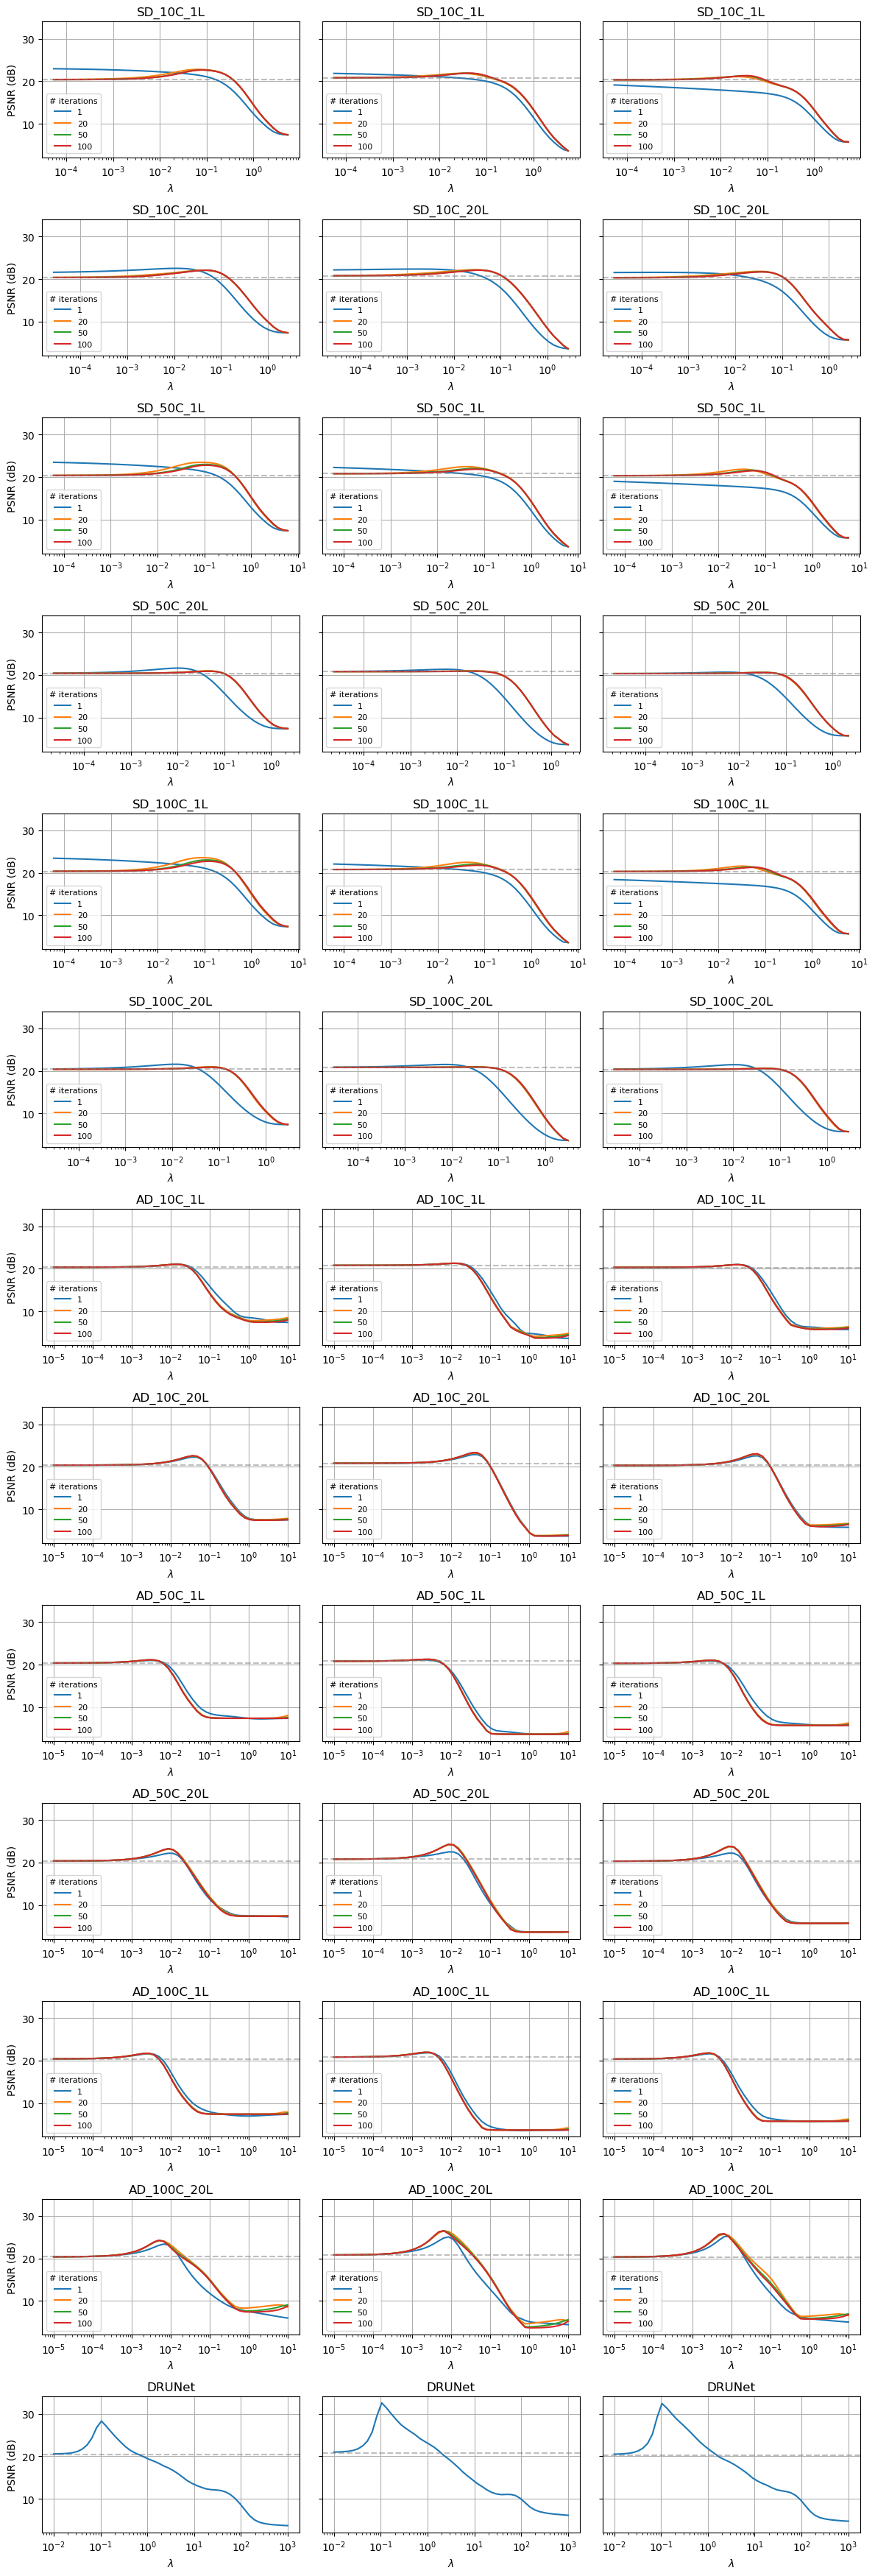

In [57]:
n_plots = len(base_names)
n_img = len(indices)

fig_lambda, axs_lambda = plt.subplots(
    n_plots+1, n_img, sharey=True, figsize=(4*n_img, 3*(n_plots+1))
)

for i, results in enumerate(list_results):
    
    x_observed = results["observation"].transpose(1, 2, 0).clip(0, 1)
    img = results["truth"].transpose(1, 2, 0).clip(0, 1)
    psnr = peak_signal_noise_ratio(img, x_observed.astype(np.float32))
    
    for k, base_name in enumerate(base_names):

        for rep in [1] + n_rep_list:
            
            name = f"{base_name}_{rep}R"
            res = results[name]
            axs_lambda[k, i].semilogx(res["lambda_list"], res['psnr'], label=rep)
        
        axs_lambda[k, i].set_title(f"{base_name}")
        axs_lambda[k, i].grid(True)
        axs_lambda[k, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
        axs_lambda[k, i].legend(title="# iterations", fontsize=8, title_fontsize=8)
        axs_lambda[k, i].set_xlabel(rf"$\lambda$")
    
    name = "DRUNet"
    res = results[name]
    axs_lambda[-1, i].semilogx(res["lambda_list"], res['psnr'])
    axs_lambda[-1, i].set_title(f"{name}")
    axs_lambda[-1, i].grid(True)
    axs_lambda[-1, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
    axs_lambda[-1, i].set_xlabel(rf"$\lambda$")

for ax in axs_lambda[:, 0]:
    ax.set_ylabel("PSNR (dB)")
fig_lambda.tight_layout(rect=[0, 0, 1, 0.9])
name_std = f"{STD_NOISE}".replace(".", "")
fig_lambda.savefig(f"warm_restart_denoising_{name_std}.pdf", bbox_inches="tight")

### STD_NOISE = 0.2

In [58]:
STD_NOISE = 0.2
pth_kernel = "blur_models/no_blur.mat"
#pth_kernel = "blur_models/blur_3.mat"

dataloader = create_dataloader(
    DATA_PATH,
    min_sigma_noise=STD_NOISE,
    max_sigma_noise=STD_NOISE,
    device=DEVICE,
    dtype=torch.float,
    mini_batch_size=1,
    train=False,
    color=COLOR,
    fixed_noise=True,
    crop=False,
)

base_names = [
    "SD_10C_1L",
    "SD_10C_20L",
    "SD_50C_1L",
    "SD_50C_20L",
    "SD_100C_1L",
    "SD_100C_20L",
    "AD_10C_1L",
    "AD_10C_20L",
    "AD_50C_1L",
    "AD_50C_20L",
    "AD_100C_1L",
    "AD_100C_20L",
]
sublist_denoisers = ["DRUNet"] + [denoiser for denoiser in DENOISERS.keys() if any(base_name in denoiser for base_name in base_names)]

indices = [0,1,2]
list_results = []
for i in indices:
    print(f"Processing image {i}...")
    img = dataloader.dataset[i][1].cpu().numpy()
    img_noise = dataloader.dataset[i][0].cpu().numpy()
    results = generate_results_pnp_warm_restart(pth_kernel, img, n_iter_per_lambda=1, n_lambda=50)
    list_results.append(results)

Processing image 0...


100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


Processing image 1...


100%|██████████| 50/50 [00:21<00:00,  2.35it/s]


Processing image 2...


100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


In [59]:
name_std = f"{STD_NOISE}".replace(".", "")
with open(f"warm_restart/results_denoising_{name_std}.pkl", "wb") as f:
    pickle.dump(list_results, f)

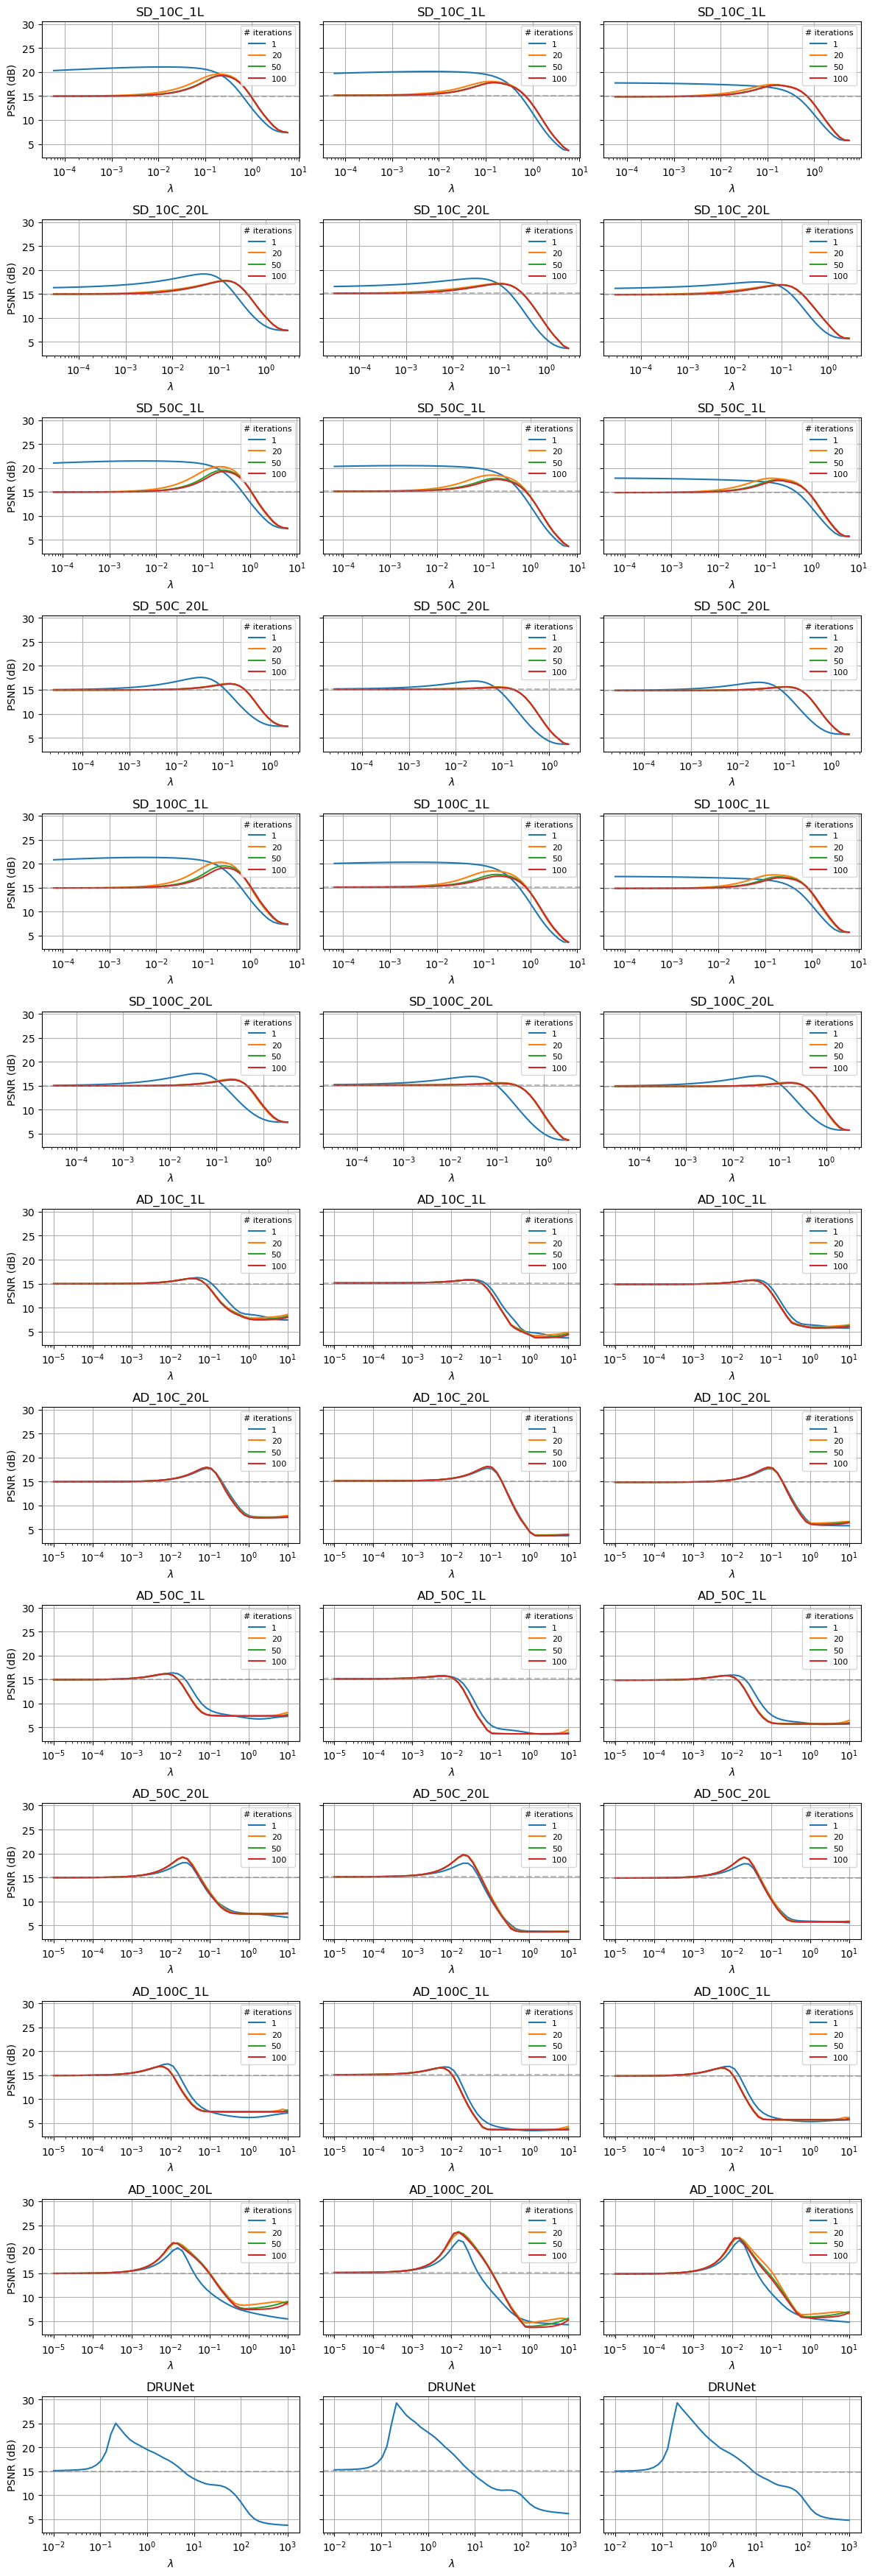

In [60]:
n_plots = len(base_names)
n_img = len(indices)

fig_lambda, axs_lambda = plt.subplots(
    n_plots+1, n_img, sharey=True, figsize=(4*n_img, 3*(n_plots+1))
)

for i, results in enumerate(list_results):
    
    x_observed = results["observation"].transpose(1, 2, 0).clip(0, 1)
    img = results["truth"].transpose(1, 2, 0).clip(0, 1)
    psnr = peak_signal_noise_ratio(img, x_observed.astype(np.float32))
    
    for k, base_name in enumerate(base_names):

        for rep in [1] + n_rep_list:
            
            name = f"{base_name}_{rep}R"
            res = results[name]
            axs_lambda[k, i].semilogx(res["lambda_list"], res['psnr'], label=rep)
        
        axs_lambda[k, i].set_title(f"{base_name}")
        axs_lambda[k, i].grid(True)
        axs_lambda[k, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
        axs_lambda[k, i].legend(title="# iterations", fontsize=8, title_fontsize=8)
        axs_lambda[k, i].set_xlabel(rf"$\lambda$")
    
    name = "DRUNet"
    res = results[name]
    axs_lambda[-1, i].semilogx(res["lambda_list"], res['psnr'])
    axs_lambda[-1, i].set_title(f"{name}")
    axs_lambda[-1, i].grid(True)
    axs_lambda[-1, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
    axs_lambda[-1, i].set_xlabel(rf"$\lambda$")

for ax in axs_lambda[:, 0]:
    ax.set_ylabel("PSNR (dB)")
fig_lambda.tight_layout(rect=[0, 0, 1, 0.9])
name_std = f"{STD_NOISE}".replace(".", "")
fig_lambda.savefig(f"warm_restart_denoising_{name_std}.pdf", bbox_inches="tight")

### STD_NOISE = 0.5

In [61]:
STD_NOISE = 0.5
pth_kernel = "blur_models/no_blur.mat"
#pth_kernel = "blur_models/blur_3.mat"

dataloader = create_dataloader(
    DATA_PATH,
    min_sigma_noise=STD_NOISE,
    max_sigma_noise=STD_NOISE,
    device=DEVICE,
    dtype=torch.float,
    mini_batch_size=1,
    train=False,
    color=COLOR,
    fixed_noise=True,
    crop=False,
)

base_names = [
    "SD_10C_1L",
    "SD_10C_20L",
    "SD_50C_1L",
    "SD_50C_20L",
    "SD_100C_1L",
    "SD_100C_20L",
    "AD_10C_1L",
    "AD_10C_20L",
    "AD_50C_1L",
    "AD_50C_20L",
    "AD_100C_1L",
    "AD_100C_20L",
]
sublist_denoisers = ["DRUNet"] + [denoiser for denoiser in DENOISERS.keys() if any(base_name in denoiser for base_name in base_names)]

indices = [0,1,2]
list_results = []
for i in indices:
    print(f"Processing image {i}...")
    img = dataloader.dataset[i][1].cpu().numpy()
    img_noise = dataloader.dataset[i][0].cpu().numpy()
    results = generate_results_pnp_warm_restart(pth_kernel, img, n_iter_per_lambda=1, n_lambda=50)
    list_results.append(results)

Processing image 0...


 14%|█▍        | 7/50 [00:00<00:05,  7.92it/s]

100%|██████████| 50/50 [00:21<00:00,  2.37it/s]


Processing image 1...


100%|██████████| 50/50 [00:21<00:00,  2.37it/s]


Processing image 2...


100%|██████████| 50/50 [00:21<00:00,  2.37it/s]


In [62]:
name_std = f"{STD_NOISE}".replace(".", "")
with open(f"warm_restart/results_denoising_{name_std}.pkl", "wb") as f:
    pickle.dump(list_results, f)

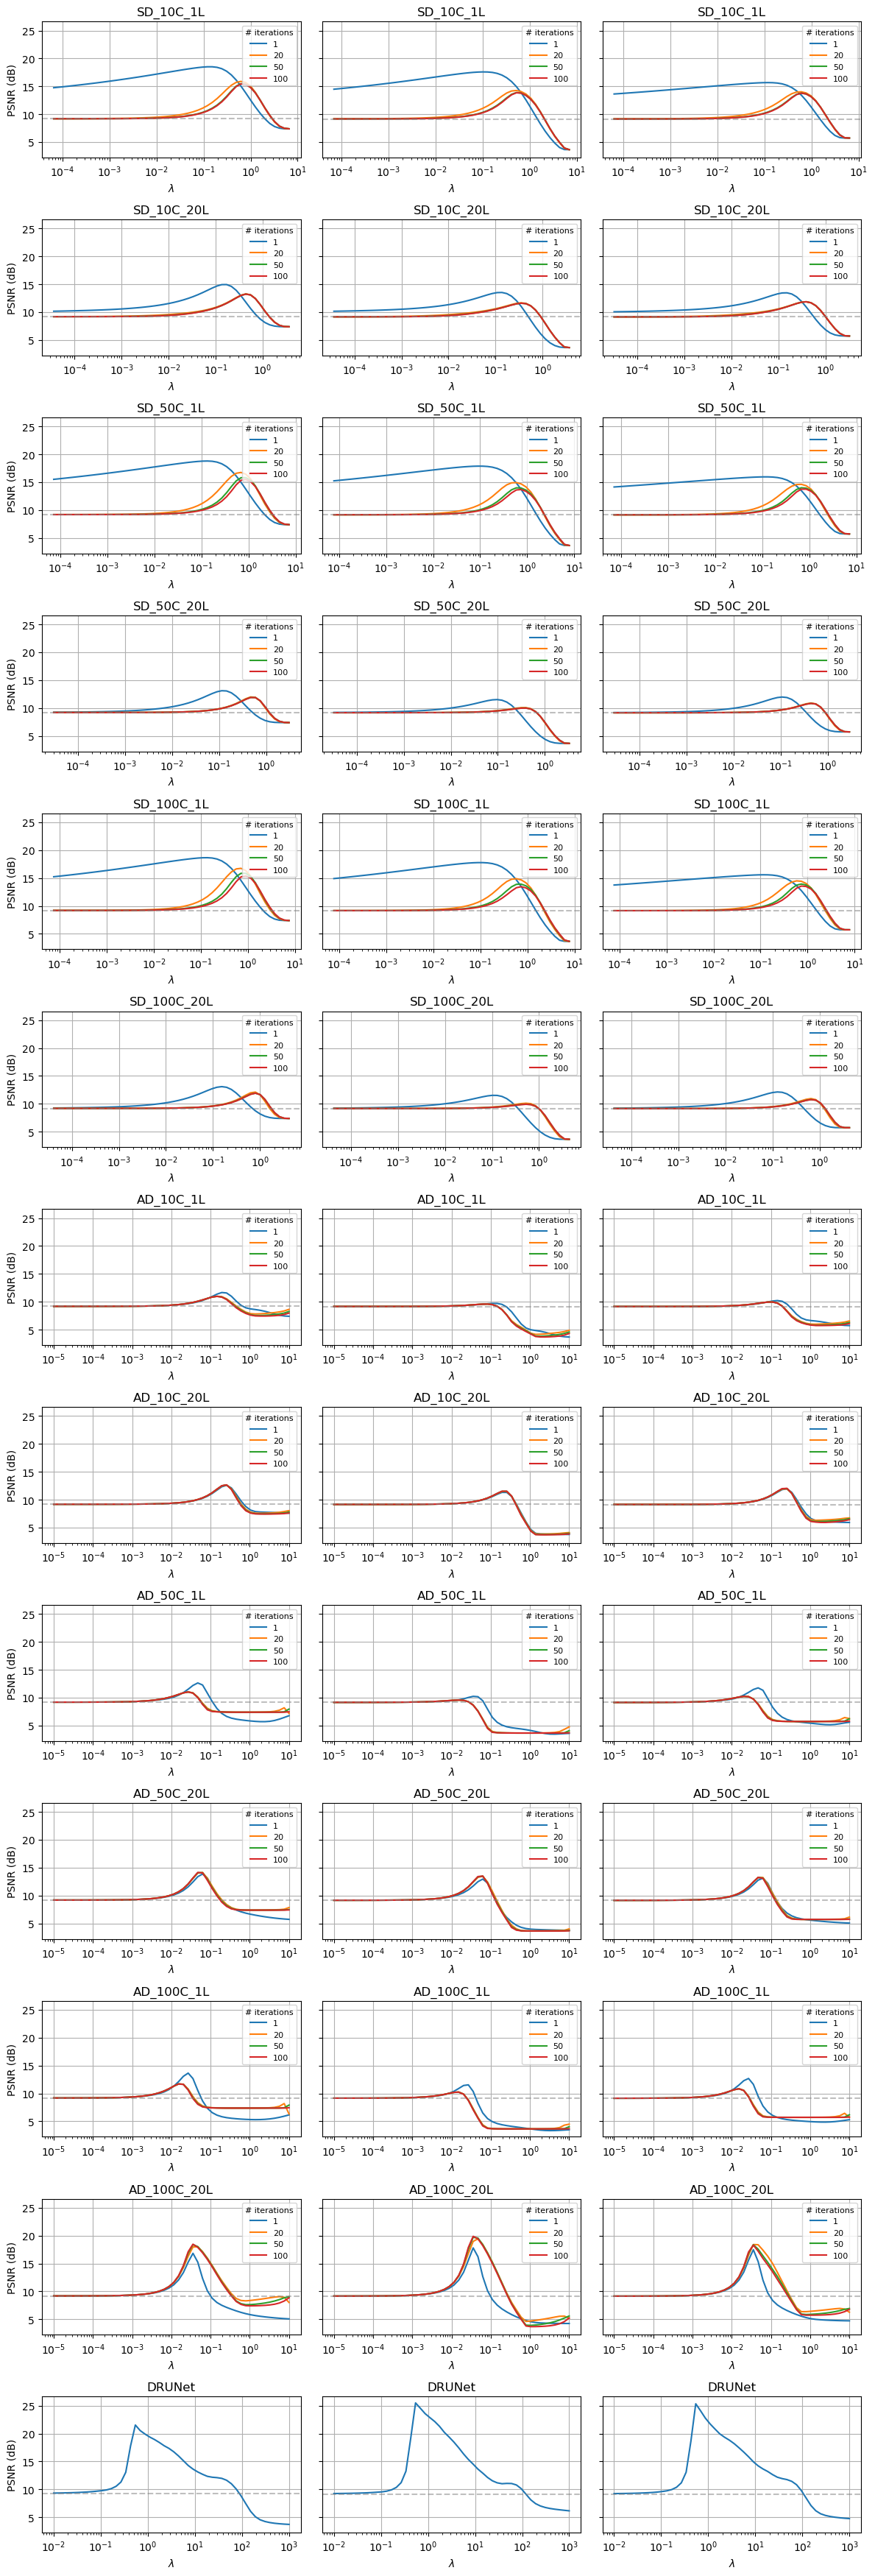

In [63]:
n_plots = len(base_names)
n_img = len(indices)

fig_lambda, axs_lambda = plt.subplots(
    n_plots+1, n_img, sharey=True, figsize=(4*n_img, 3*(n_plots+1))
)

for i, results in enumerate(list_results):
    
    x_observed = results["observation"].transpose(1, 2, 0).clip(0, 1)
    img = results["truth"].transpose(1, 2, 0).clip(0, 1)
    psnr = peak_signal_noise_ratio(img, x_observed.astype(np.float32))
    
    for k, base_name in enumerate(base_names):

        for rep in [1] + n_rep_list:
            
            name = f"{base_name}_{rep}R"
            res = results[name]
            axs_lambda[k, i].semilogx(res["lambda_list"], res['psnr'], label=rep)
        
        axs_lambda[k, i].set_title(f"{base_name}")
        axs_lambda[k, i].grid(True)
        axs_lambda[k, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
        axs_lambda[k, i].legend(title="# iterations", fontsize=8, title_fontsize=8)
        axs_lambda[k, i].set_xlabel(rf"$\lambda$")
    
    name = "DRUNet"
    res = results[name]
    axs_lambda[-1, i].semilogx(res["lambda_list"], res['psnr'])
    axs_lambda[-1, i].set_title(f"{name}")
    axs_lambda[-1, i].grid(True)
    axs_lambda[-1, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
    axs_lambda[-1, i].set_xlabel(rf"$\lambda$")

for ax in axs_lambda[:, 0]:
    ax.set_ylabel("PSNR (dB)")
fig_lambda.tight_layout(rect=[0, 0, 1, 0.9])
name_std = f"{STD_NOISE}".replace(".", "")
fig_lambda.savefig(f"warm_restart_denoising_{name_std}.pdf", bbox_inches="tight")

### STD_NOISE = 2.0

In [64]:
STD_NOISE = 2.0
pth_kernel = "blur_models/no_blur.mat"
#pth_kernel = "blur_models/blur_3.mat"

dataloader = create_dataloader(
    DATA_PATH,
    min_sigma_noise=STD_NOISE,
    max_sigma_noise=STD_NOISE,
    device=DEVICE,
    dtype=torch.float,
    mini_batch_size=1,
    train=False,
    color=COLOR,
    fixed_noise=True,
    crop=False,
)

base_names = [
    "SD_10C_1L",
    "SD_10C_20L",
    "SD_50C_1L",
    "SD_50C_20L",
    "SD_100C_1L",
    "SD_100C_20L",
    "AD_10C_1L",
    "AD_10C_20L",
    "AD_50C_1L",
    "AD_50C_20L",
    "AD_100C_1L",
    "AD_100C_20L",
]
sublist_denoisers = ["DRUNet"] + [denoiser for denoiser in DENOISERS.keys() if any(base_name in denoiser for base_name in base_names)]

indices = [0,1,2]
list_results = []
for i in indices:
    print(f"Processing image {i}...")
    img = dataloader.dataset[i][1].cpu().numpy()
    img_noise = dataloader.dataset[i][0].cpu().numpy()
    results = generate_results_pnp_warm_restart(pth_kernel, img, n_iter_per_lambda=1, n_lambda=50)
    list_results.append(results)

Processing image 0...


  6%|▌         | 3/50 [00:00<00:05,  7.97it/s]

100%|██████████| 50/50 [00:21<00:00,  2.37it/s]


Processing image 1...


100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


Processing image 2...


100%|██████████| 50/50 [00:21<00:00,  2.37it/s]


In [65]:
name_std = f"{STD_NOISE}".replace(".", "")
with open(f"warm_restart/results_denoising_{name_std}.pkl", "wb") as f:
    pickle.dump(list_results, f)

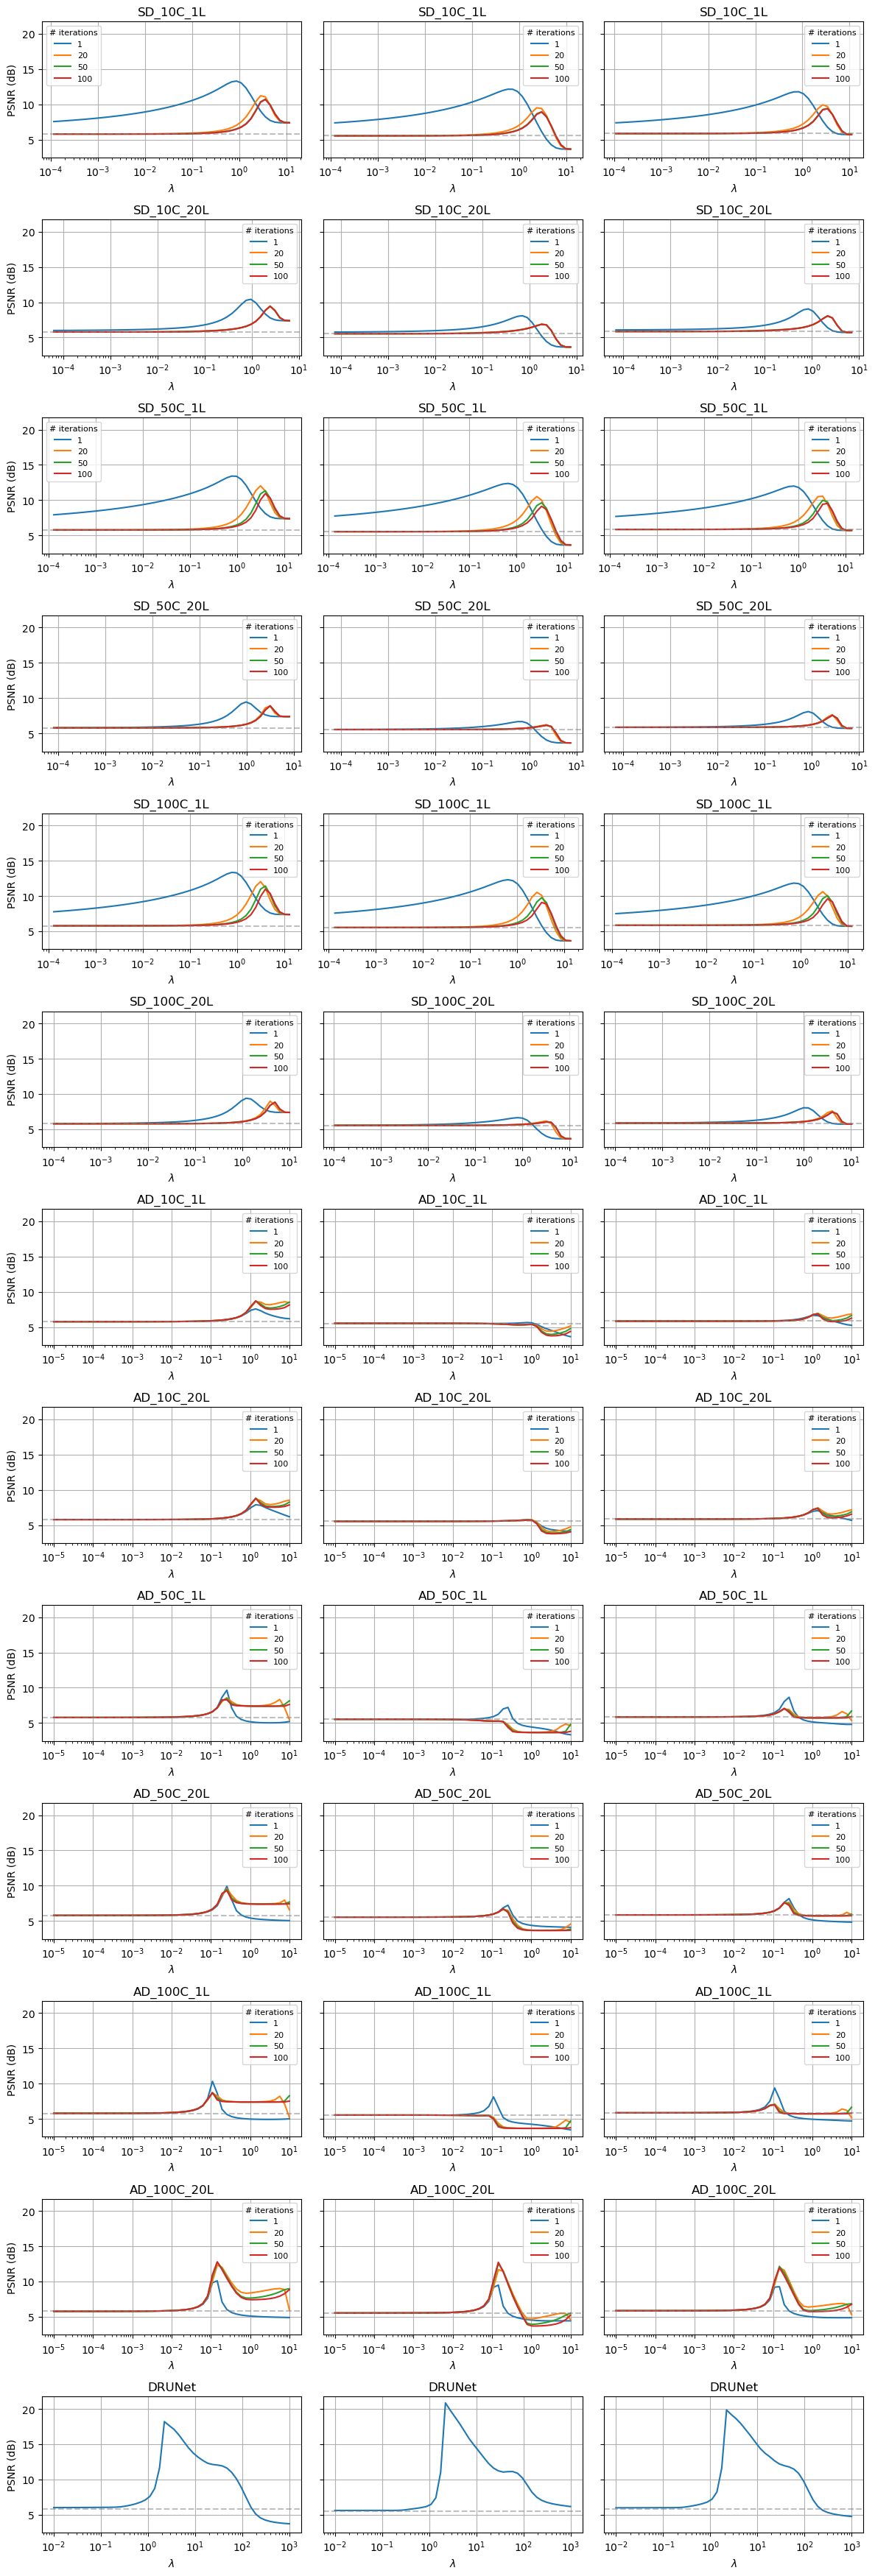

In [66]:
n_plots = len(base_names)
n_img = len(indices)

fig_lambda, axs_lambda = plt.subplots(
    n_plots+1, n_img, sharey=True, figsize=(4*n_img, 3*(n_plots+1))
)

for i, results in enumerate(list_results):
    
    x_observed = results["observation"].transpose(1, 2, 0).clip(0, 1)
    img = results["truth"].transpose(1, 2, 0).clip(0, 1)
    psnr = peak_signal_noise_ratio(img, x_observed.astype(np.float32))
    
    for k, base_name in enumerate(base_names):

        for rep in [1] + n_rep_list:
            
            name = f"{base_name}_{rep}R"
            res = results[name]
            axs_lambda[k, i].semilogx(res["lambda_list"], res['psnr'], label=rep)
        
        axs_lambda[k, i].set_title(f"{base_name}")
        axs_lambda[k, i].grid(True)
        axs_lambda[k, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
        axs_lambda[k, i].legend(title="# iterations", fontsize=8, title_fontsize=8)
        axs_lambda[k, i].set_xlabel(rf"$\lambda$")
    
    name = "DRUNet"
    res = results[name]
    axs_lambda[-1, i].semilogx(res["lambda_list"], res['psnr'])
    axs_lambda[-1, i].set_title(f"{name}")
    axs_lambda[-1, i].grid(True)
    axs_lambda[-1, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
    axs_lambda[-1, i].set_xlabel(rf"$\lambda$")

for ax in axs_lambda[:, 0]:
    ax.set_ylabel("PSNR (dB)")
fig_lambda.tight_layout(rect=[0, 0, 1, 0.9])
name_std = f"{STD_NOISE}".replace(".", "")
fig_lambda.savefig(f"warm_restart_denoising_{name_std}.pdf", bbox_inches="tight")

## No warm-restart

In [90]:
STD_NOISE = 0.1
pth_kernel = "blur_models/no_blur.mat"
#pth_kernel = "blur_models/blur_3.mat"

dataloader = create_dataloader(
    DATA_PATH,
    min_sigma_noise=STD_NOISE,
    max_sigma_noise=STD_NOISE,
    device=DEVICE,
    dtype=torch.float,
    mini_batch_size=1,
    train=False,
    color=COLOR,
    fixed_noise=True,
    crop=False,
)

base_names = [
    "SD_10C_1L",
    "SD_10C_20L",
    "SD_50C_1L",
    "SD_50C_20L",
    # "SD_100C_1L",
    # "SD_100C_20L",
    # "AD_10C_1L",
    # "AD_10C_20L",
    # "AD_50C_1L",
    # "AD_50C_20L",
    # "AD_100C_1L",
    # "AD_100C_20L",
]
sublist_denoisers = ["DRUNet"] + [denoiser for denoiser in DENOISERS.keys() if any(base_name in denoiser for base_name in base_names)]

indices = [0,1]#,2]
list_results = []
for i in indices:
    print(f"Processing image {i}...")
    img = dataloader.dataset[i][1].cpu().numpy()
    img_noise = dataloader.dataset[i][0].cpu().numpy()
    results = generate_results_pnp(pth_kernel, img, n_iter_per_lambda=1, n_lambda=50, warm_restart=False)
    list_results.append(results)

Processing image 0...


  0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_3095325/3577001064.py:49: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_bis[i] = peak_signal_noise_ratio(x_n, x_observed)
100%|██████████| 50/50 [00:13<00:00,  3.81it/s]


Processing image 1...


100%|██████████| 50/50 [00:13<00:00,  3.77it/s]


In [ ]:
name_std = f"{STD_NOISE}".replace(".", "")
with open(f"warm_restart/results_denoising_{name_std}_no_warm_restart.pkl", "wb") as f:
    pickle.dump(list_results, f)

KeyboardInterrupt: 

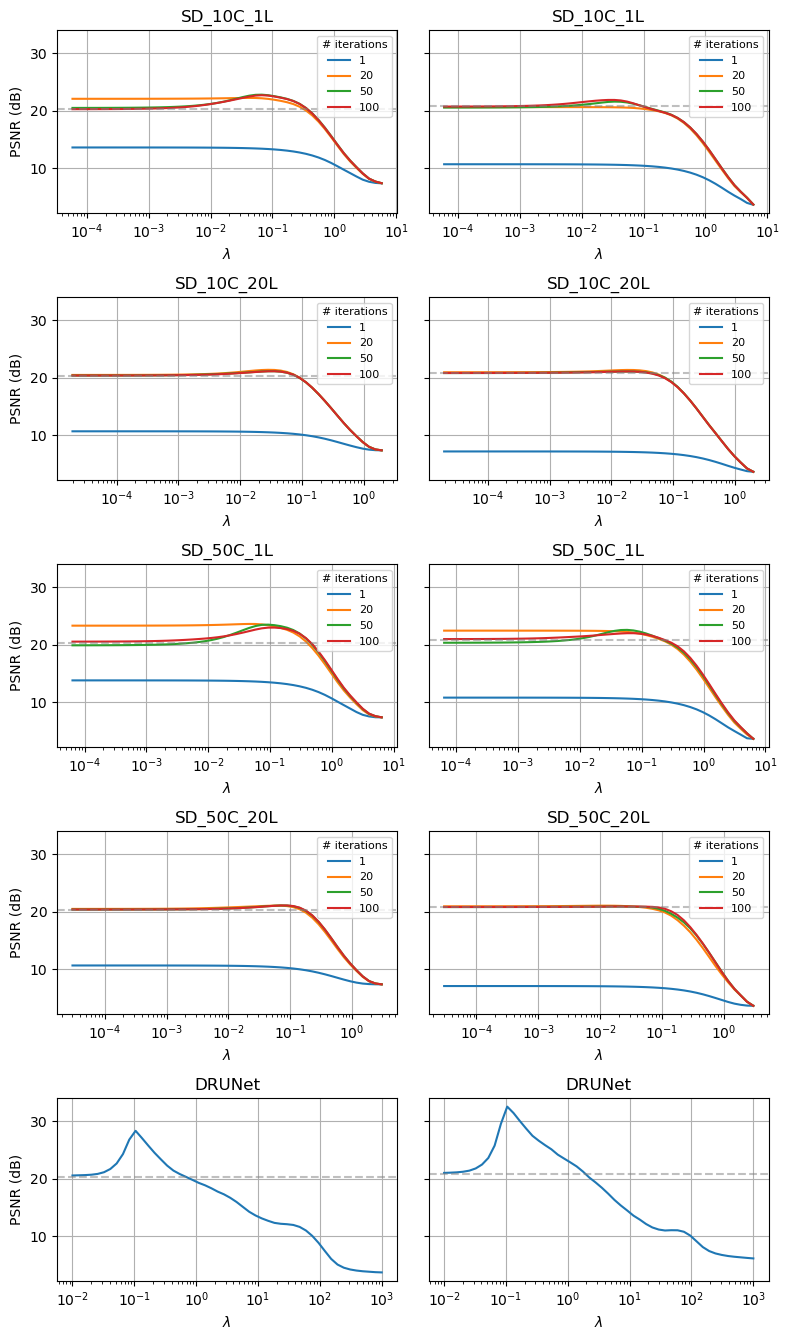

In [ ]:
n_plots = len(base_names)
n_img = len(indices)

fig_lambda, axs_lambda = plt.subplots(
    n_plots+1, n_img, sharey=True, figsize=(4*n_img, 3*(n_plots+1))
)

for i, results in enumerate(list_results):
    
    x_observed = results["observation"].transpose(1, 2, 0).clip(0, 1)
    img = results["truth"].transpose(1, 2, 0).clip(0, 1)
    psnr = peak_signal_noise_ratio(img, x_observed.astype(np.float32))
    
    for k, base_name in enumerate(base_names):

        for rep in [1] + n_rep_list:
            
            name = f"{base_name}_{rep}R"
            res = results[name]
            axs_lambda[k, i].semilogx(res["lambda_list"], res['psnr'], label=rep)
        
        axs_lambda[k, i].set_title(f"{base_name}")
        axs_lambda[k, i].grid(True)
        axs_lambda[k, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
        axs_lambda[k, i].legend(title="# iterations", fontsize=8, title_fontsize=8)
        axs_lambda[k, i].set_xlabel(rf"$\lambda$")
    
    name = "DRUNet"
    res = results[name]
    axs_lambda[-1, i].semilogx(res["lambda_list"], res['psnr'])
    axs_lambda[-1, i].set_title(f"{name}")
    axs_lambda[-1, i].grid(True)
    axs_lambda[-1, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
    axs_lambda[-1, i].set_xlabel(rf"$\lambda$")

for ax in axs_lambda[:, 0]:
    ax.set_ylabel("PSNR (dB)")
fig_lambda.tight_layout(rect=[0, 0, 1, 0.9])
name_std = f"{STD_NOISE}".replace(".", "")

## Deblurring

In [122]:
STD_NOISE = 0.1
#pth_kernel = "blur_models/no_blur.mat"
pth_kernel = "blur_models/blur_3.mat"

dataloader = create_dataloader(
    DATA_PATH,
    min_sigma_noise=STD_NOISE,
    max_sigma_noise=STD_NOISE,
    device=DEVICE,
    dtype=torch.float,
    mini_batch_size=1,
    train=False,
    color=COLOR,
    fixed_noise=True,
    crop=False,
)

base_names = [
    "SD_10C_1L",
    "SD_10C_20L",
    "SD_50C_1L",
    "SD_50C_20L",
    "SD_100C_1L",
    "SD_100C_20L"
    # "AD_10C_1L",
    # "AD_10C_20L",
    # "AD_50C_1L",
    # "AD_50C_20L",
    # "AD_100C_1L",
    # "AD_100C_20L",
]



sublist_denoisers = ["DRUNet"] + [denoiser for denoiser in DENOISERS.keys() if any(base_name in denoiser for base_name in base_names)]
#sublist_denoisers = ["SD_10C_20L_1R", "SD_10C_20L_20R", "SD_10C_20L_50R", "SD_10C_20L_100R"]

indices = [1,3]#,2]
list_results = []
n_iter_per_lambda = 50
n_lambda = 50
eps_stop = 5e-5
for i in indices:
    print(f"Processing image {i}...")
    img = dataloader.dataset[i][1].cpu().numpy()
    img_noise = dataloader.dataset[i][0].cpu().numpy()
    results = generate_results_pnp(pth_kernel, img, n_iter_per_lambda=n_iter_per_lambda, n_lambda=n_lambda, eps_stop=eps_stop)
    list_results.append(results)

Processing image 1...
Hehe 1
Hehe 2
sub-Hehe 3


  0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_3095325/214074771.py:52: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_bis[i] = peak_signal_noise_ratio(x_n, x_observed)
100%|██████████| 50/50 [00:15<00:00,  3.22it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:13<00:00,  3.74it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:12<00:00,  4.12it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:17<00:00,  2.89it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:16<00:00,  3.11it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:17<00:00,  2.91it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:19<00:00,  2.54it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:24<00:00,  2.01it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:18<00:00,  2.77it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:17<00:00,  2.93it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:21<00:00,  2.30it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:29<00:00,  1.69it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:18<00:00,  2.71it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:23<00:00,  2.13it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:25<00:00,  1.95it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:37<00:00,  1.35it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:17<00:00,  2.86it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:18<00:00,  2.69it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:30<00:00,  1.65it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:20<00:00,  2.42it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:25<00:00,  1.98it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:33<00:00,  1.48it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:53<00:00,  1.08s/it]


Processing image 3...
Hehe 1
Hehe 2
sub-Hehe 3


100%|██████████| 50/50 [00:41<00:00,  1.20it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:21<00:00,  2.32it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:20<00:00,  2.40it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:32<00:00,  1.53it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:43<00:00,  1.16it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:28<00:00,  1.77it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:24<00:00,  2.02it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:33<00:00,  1.50it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:41<00:00,  1.22it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:26<00:00,  1.88it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:28<00:00,  1.76it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:58<00:00,  1.18s/it]


sub-Hehe 3


100%|██████████| 50/50 [00:33<00:00,  1.50it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:35<00:00,  1.42it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


sub-Hehe 3


100%|██████████| 50/50 [01:01<00:00,  1.22s/it]


sub-Hehe 3


100%|██████████| 50/50 [00:24<00:00,  2.08it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:30<00:00,  1.63it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:54<00:00,  1.08s/it]


sub-Hehe 3


100%|██████████| 50/50 [01:28<00:00,  1.76s/it]


sub-Hehe 3


100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:36<00:00,  1.39it/s]


sub-Hehe 3


100%|██████████| 50/50 [00:56<00:00,  1.14s/it]


sub-Hehe 3


100%|██████████| 50/50 [01:26<00:00,  1.74s/it]


In [ ]:
fig, axs = plt.subplots(len(sublist_denoisers), n_lambda, figsize=(4*n_lambda, 3.5*len(sublist_denoisers)))

for i in range(len(sublist_denoisers)):
    axs[i, 0].set_ylabel(sublist_denoisers[i])
    res = list_results[0][sublist_denoisers[i]]
    
    for j in range(n_lambda):
        axs[i, j].plot(res["psnr_bis"][res["stops"][j]:res["stops"][j+1]])
        axs[i, j].set_title(rf"$\lambda=${res['lambda_list'][j]:.2e}")

fig.savefig(f"warm_restart_deblurring_stop.pdf", bbox_inches="tight") 

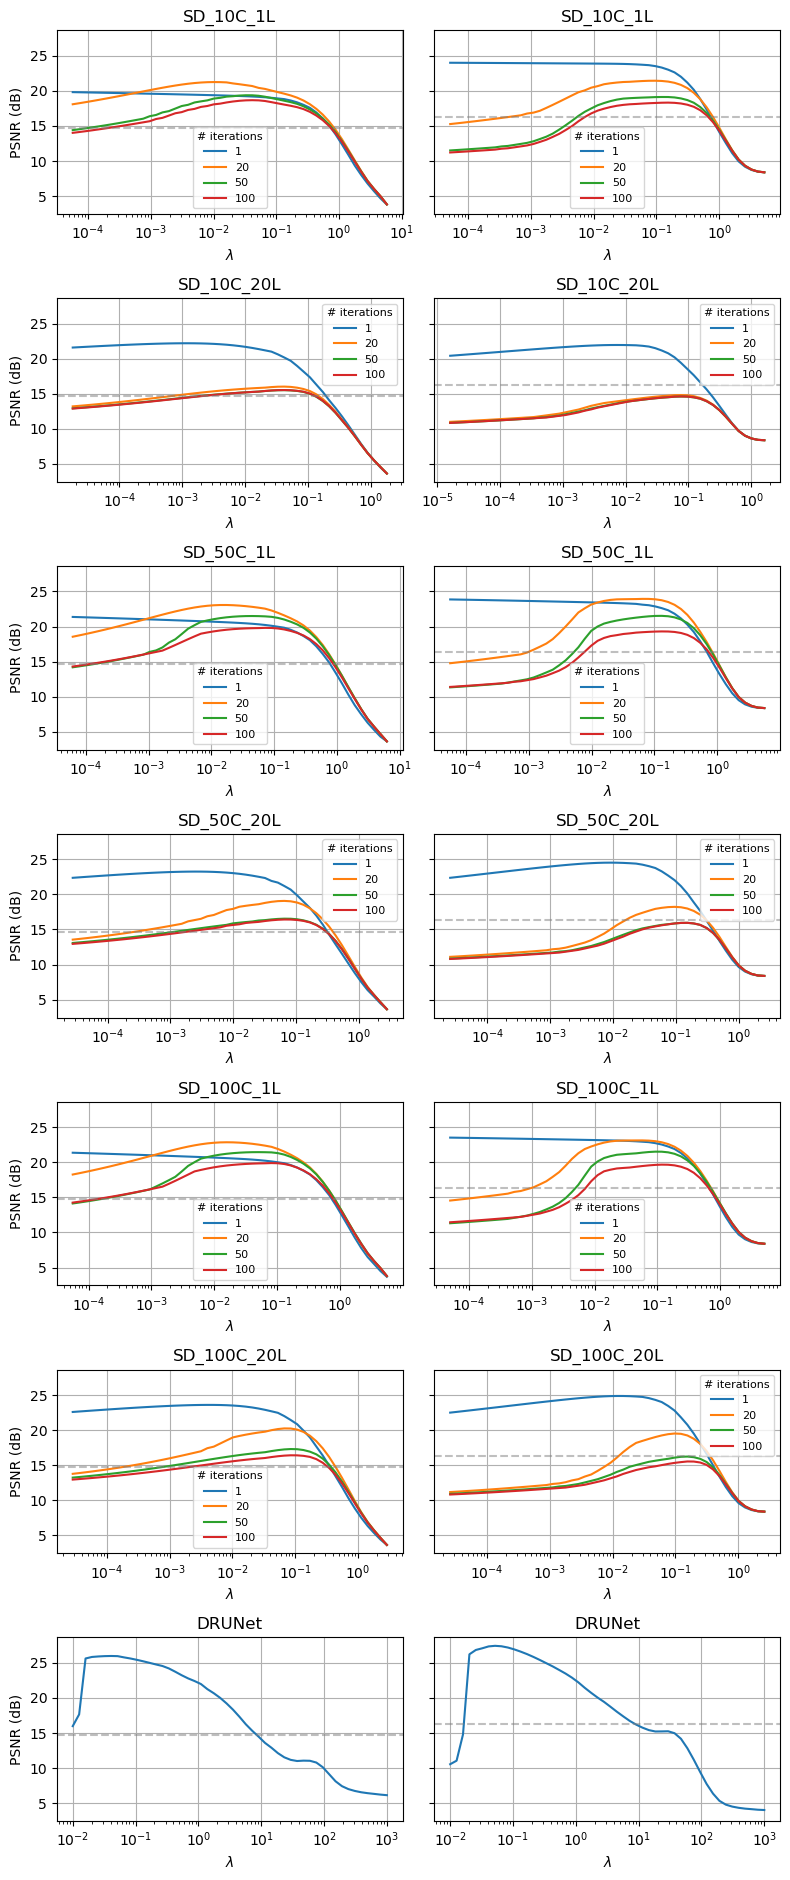

In [124]:
n_plots = len(base_names)
n_img = len(indices)

fig_lambda, axs_lambda = plt.subplots(
    n_plots+1, n_img, sharey=True, figsize=(4*n_img, 3*(n_plots+1))
)

for i, results in enumerate(list_results):
    
    x_observed = results["observation"].transpose(1, 2, 0).clip(0, 1)
    img = results["truth"].transpose(1, 2, 0).clip(0, 1)
    psnr = peak_signal_noise_ratio(img, x_observed.astype(np.float32))
    
    for k, base_name in enumerate(base_names):

        for rep in [1] + n_rep_list:
            
            name = f"{base_name}_{rep}R"
            res = results[name]
            axs_lambda[k, i].semilogx(res["lambda_list"], res['psnr'], label=rep)
        
        axs_lambda[k, i].set_title(f"{base_name}")
        axs_lambda[k, i].grid(True)
        axs_lambda[k, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
        axs_lambda[k, i].legend(title="# iterations", fontsize=8, title_fontsize=8)
        axs_lambda[k, i].set_xlabel(rf"$\lambda$")
    
    name = "DRUNet"
    res = results[name]
    axs_lambda[-1, i].semilogx(res["lambda_list"], res['psnr'])
    axs_lambda[-1, i].set_title(f"{name}")
    axs_lambda[-1, i].grid(True)
    axs_lambda[-1, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
    axs_lambda[-1, i].set_xlabel(rf"$\lambda$")

for ax in axs_lambda[:, 0]:
    ax.set_ylabel("PSNR (dB)")
fig_lambda.tight_layout(rect=[0, 0, 1, 0.9])
name_std = f"{STD_NOISE}".replace(".", "")
fig_lambda.savefig(f"warm_restart_deblurring_{name_std}.pdf", bbox_inches="tight")